# Galaxias en VVV

## Clasificacion con Machine Learning
### Objetos visualmente confirmados VS.  Objetos candidatos

Usamos un catálogo de galaxias identificadas en VVV en los tiles **d010** y **d0115** de Baravalle L.

Para saber donde estan ubicados los tiles usamos el mapa de VVV

<img src='./imgs/survey-area-tile-nbrs-copy2.jpg'>

En estos tiles encontraron 574 objetos con propiedades morfologicas, fotometricas y fotocromaticas propias de galaxias. 90 de los mismos han sido visualmente inspeccionados, y constituyen una muestra *bona fide* de galaxias en el VVV.

## Analisis de los datos

Primero cargamos las librerias necesarias

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from astropy.io import ascii
from astropy.table import Table, Column

%matplotlib inline

Leemos los datos de la tabla de Baravalle et al. 2017

El catálogo se encuentra en formato **cds**, pero hubo que modificar los datos perdidos.
Simplemente se reemplazaron los valores `--` por espacios vacios.

In [66]:
cat = ascii.read('Table1.all.txt', format='cds')

----------------------

Se crea una columna donde podamos marcar los objetos identificados visualmente.

In [67]:
visual = []
for row in cat:
    if row['Id'].endswith('*'):
        visual.append(1)
    else: visual.append(0)

In [68]:
vis = Column(data=visual, name='Visual', dtype='Bool')
cat.add_column(vis)

El catalogo entonces quedaría con esta pinta:

In [71]:
cat

Id,RAh,RAm,RAs,DE-,DEd,DEm,DEs,Z,Y,J,H,Ks,Z$_{2\prime\prime}$,Y$_{2\prime\prime}$,J$_{2\prime\prime}$,H$_{2\prime\prime}$,Ks$_{2\prime\prime}$,R$_{1/2}$,C,$\epsilon$,n,Visual
,h,min,s,-,deg,arcmin,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,arcsec,,,,
str24,int64,int64,float64,str1,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
VVV-J114419.03-603025.9,11,44,19.03,-,60,30,25.9,15.86,15.85,15.76,15.3,15.02,15.94,15.96,15.77,15.19,15.06,2.46,3.54,0.14,3.97,False
VVV-J114428.39-603158.4,11,44,28.39,-,60,31,58.4,--,--,17.17,17.0,16.44,--,--,17.14,16.91,16.46,1.03,2.34,0.5,7.38,False
VVV-J114431.78-601626.8,11,44,31.78,-,60,16,26.8,--,--,16.81,16.34,16.27,--,--,16.82,16.35,16.25,1.25,3.34,0.1,7.18,False
VVV-J114433.70-602742.8,11,44,33.7,-,60,27,42.8,16.82,16.78,16.63,16.2,16.11,16.77,16.83,16.65,16.13,16.08,1.09,2.56,0.18,4.12,False
VVV-J114450.83-603356.9,11,44,50.83,-,60,33,56.9,17.18,17.02,16.75,16.22,16.06,16.97,17.16,16.8,16.13,16.05,2.2,3.65,0.43,8.36,False
VVV-J114453.09-601805.8,11,44,53.09,-,60,18,5.8,16.38,16.35,16.28,15.75,15.73,16.36,16.4,16.29,15.77,15.72,1.48,2.97,0.46,4.62,False
VVV-J114455.73-600020.9,11,44,55.73,-,60,0,20.9,17.26,17.17,17.03,16.66,16.5,17.2,17.28,17.06,16.64,16.46,1.48,2.66,0.26,1.15,False
VVV-J114456.52-603249.6,11,44,56.52,-,60,32,49.6,--,--,16.56,16.02,15.86,--,--,16.6,15.96,15.89,1.25,2.46,0.35,2.64,False


Guardamos el catalogo en formato `csv` para conservar la columna con identificacion visual

In [72]:
cat.write('cat_lau.csv', format='csv', overwrite=True)

Veamos las distribuciones y dependencias de los datos.

In [73]:
pdcat = cat.to_pandas()
print pdcat.columns

Index([u'Id', u'RAh', u'RAm', u'RAs', u'DE-', u'DEd', u'DEm', u'DEs', u'Z',
       u'Y', u'J', u'H', u'Ks', u'Z$_{2\prime\prime}$', u'Y$_{2\prime\prime}$',
       u'J$_{2\prime\prime}$', u'H$_{2\prime\prime}$', u'Ks$_{2\prime\prime}$',
       u'R$_{1/2}$', u'C', u'$\epsilon$', u'n', u'Visual'],
      dtype='object')


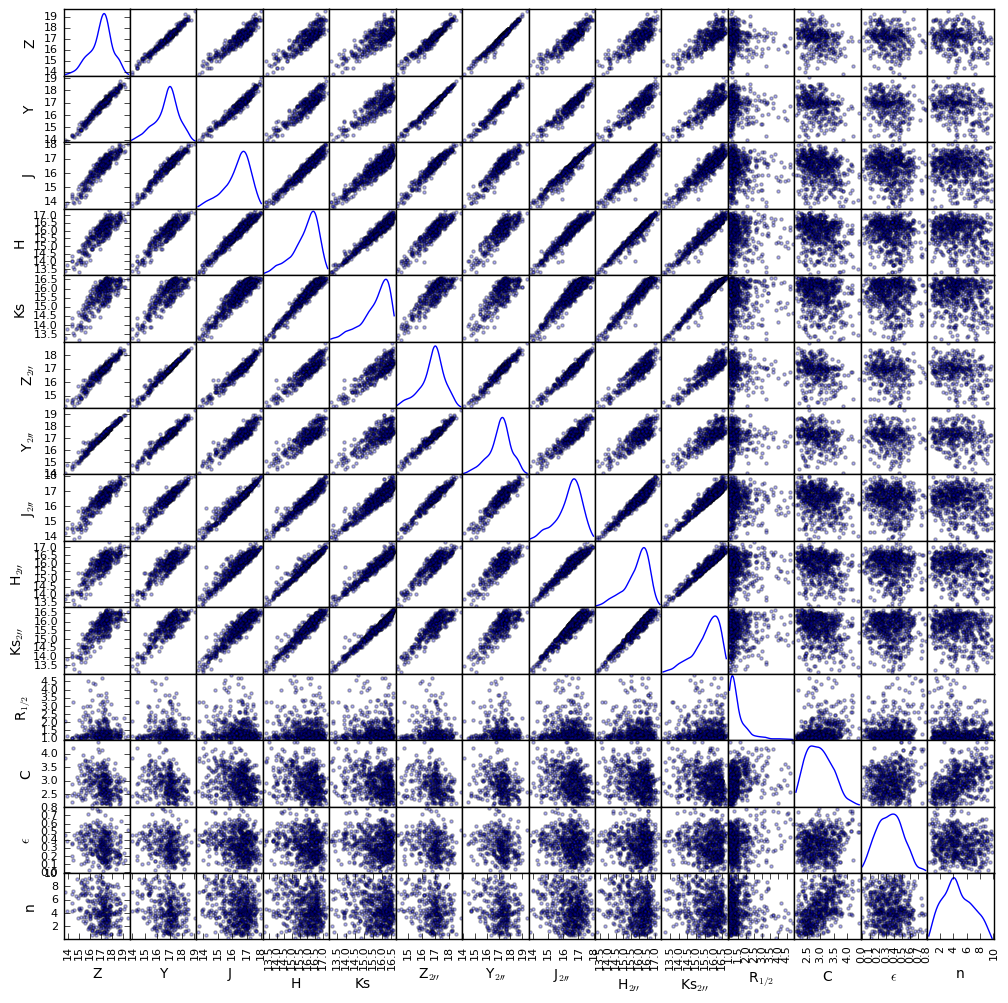

In [74]:
numeric_cols = pdcat[[u'Z', u'Y', u'J', u'H', u'Ks', u'Z$_{2\prime\prime}$', u'Y$_{2\prime\prime}$', 
                      u'J$_{2\prime\prime}$', u'H$_{2\prime\prime}$', u'Ks$_{2\prime\prime}$', 
                      u'R$_{1/2}$', u'C', u'$\epsilon$', u'n']]
pd.scatter_matrix(numeric_cols,  alpha=0.3, figsize=(12, 12), diagonal='kde')
plt.show()

Ahora que hemos chequeado las distribuciones de los valores de magnitudes y parametros extra podemos ver que a simple vista la muestra proviene de una misma poblacion de objetos.

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import neighbors
import sklearn.cross_validation as cv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [76]:
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

In [98]:
X = pdcat[[u'J', u'H', u'Ks', 
           u'J$_{2\prime\prime}$', u'H$_{2\prime\prime}$', u'Ks$_{2\prime\prime}$', 
           u'R$_{1/2}$', u'C', u'$\epsilon$', u'n']]
X = X.as_matrix()

# Y = pdcat[u'Visual']
# Y = Y.as_matrix()

Y = np.asarray(pdcat['Visual'], dtype="int")

In [99]:
X = np.delete(X, [[378, 442]], axis=0)
Y = np.delete(Y, [[378, 442]], axis=0)

In [121]:
res_Dtree = experiment(DecisionTreeClassifier(max_leaf_nodes=5), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.86      0.95      0.90       482
        1.0       0.34      0.14      0.20        90

avg / total       0.77      0.82      0.79       572



In [122]:
res_knn = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.86      0.92      0.89       482
        1.0       0.29      0.17      0.21        90

avg / total       0.77      0.80      0.78       572



In [123]:
res_svc = experiment(svm.SVC(kernel='linear', probability=True), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.84      1.00      0.91       482
        1.0       0.00      0.00      0.00        90

avg / total       0.71      0.84      0.77       572



In [124]:
res_Rforest = experiment(RandomForestClassifier(n_estimators=100, min_samples_leaf=5), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.85      0.98      0.91       482
        1.0       0.29      0.06      0.09        90

avg / total       0.76      0.83      0.78       572



In [125]:
res_C45 = experiment(DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=5), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.84      1.00      0.91       482
        1.0       0.00      0.00      0.00        90

avg / total       0.71      0.84      0.77       572



Ahora que probamos con varios clasificadores podemos construir una curva ROC

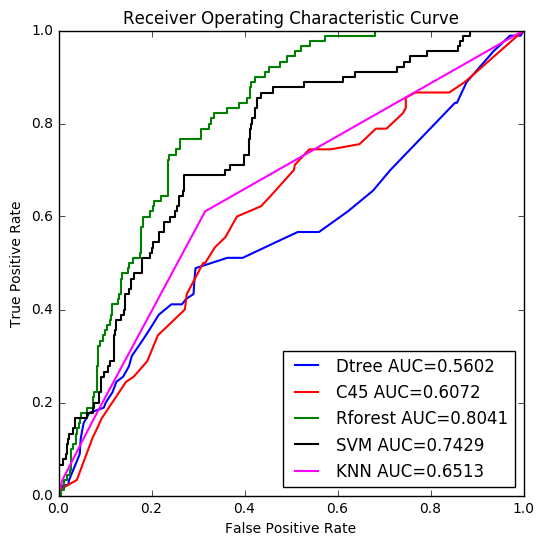

In [127]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

fpr = res_Dtree['fpr']
tpr = res_Dtree['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

fpr = res_C45['fpr']
tpr = res_C45['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

fpr = res_Rforest['fpr']
tpr = res_Rforest['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

fpr = res_svc['fpr']
tpr = res_svc['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

fpr = res_knn['fpr']
tpr = res_knn['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic Curve')